In [ ]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00


In [ ]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 1.8 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon

In [ ]:
# выводим центроиды полигонов
def get_lat_lon(geometry):

    lon = geometry.apply(lambda x: x.x if x.type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.type == 'Point' else x.centroid.y)
    return lat, lon
# выгрузим границы ЕКБ из OSM
cities = ['Екатеринбург']
polygon_krd = ox.features_from_place(cities, {'boundary':'administrative'}).reset_index()
polygon_krd = polygon_krd[(polygon_krd['name'] == 'городской округ Екатеринбург')]

In [ ]:
def create_hexagons(geoJson):

    polyline = geoJson['coordinates'][0]

    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
    m.add_child(my_PolyLine)

    hexagons = list(h3.polyfill(geoJson, 8))
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=3,color='red')
        m.add_child(my_PolyLine)

    polylines_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:,1],np.array(polylines[j])[:,0])).tolist()
        polylines_x.append([(a[i][0], a[i][1]) for i in range(len(a))])

    polygons_hex = pd.Series(polylines_x).apply(lambda x: Polygon(x))

    return m, polygons_hex, polylines
# polygon_hex , polylines - геометрии гексагонов в разных форматах

# сгенерим гексагоны внутри полигона г. Екатеринбург
geoJson = json.loads(gpd.GeoSeries(polygon_krd['geometry']).to_json())
geoJson = geoJson['features'][0]['geometry']
geoJson = {'type':'Polygon','coordinates': [np.column_stack((np.array(geoJson['coordinates'][0])[:, 1],
                                                      np.array(geoJson['coordinates'][0])[:, 0])).tolist()]}

m, polygons, polylines = create_hexagons(geoJson)

In [ ]:
def osm_query(tag, city):
    gdf = ox.features_from_place(city, tag).reset_index()
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    gdf = gdf[['city', 'object', 'type', 'geometry']]
    print(gdf.shape)
    return gdf

 # Выгрузим интересующие нас категории объектов
tags = [
        {'building' : 'school'}, {'building' : 'university'},
        {'building':'college'},
        {'amenity':'school'}, {'amenity':'university'},
        {'amenity':'college'},  {'amenity':'bar'},
        {'shop':'alcohol'}

       ]
cities = ['Екатеринбург, Россия']

gdfs = []
for city in cities:
    for tag in tags:
        gdfs.append(osm_query(tag, city))

# посмотрим что получилось
data_poi = pd.concat(gdfs)
data_poi.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})

# добавим координаты/центроиды
lat, lon = get_lat_lon(data_poi['geometry'])
data_poi['lat'] = lat
data_poi['lon'] = lon

(222, 4)
(44, 4)
(15, 4)
(250, 4)
(55, 4)
(56, 4)
(130, 4)
(376, 4)


<ipython-input-6-f0494d2b08c5>:4: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  lon = geometry.apply(lambda x: x.x if x.type == 'Point' else x.centroid.x)
<ipython-input-6-f0494d2b08c5>:5: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  lat = geometry.apply(lambda x: x.y if x.type == 'Point' else x.centroid.y)


In [ ]:
options = ['school', 'university', 'college']

data_poi_uch_zav = data_poi[data_poi['type'].isin(options)]

In [ ]:
latitude_uch_zav = data_poi_uch_zav['lat']

In [ ]:
longitude_uch_zav = data_poi_uch_zav['lon']

In [ ]:
options = ['bar', 'alcohol']

data_poi_alco = data_poi[data_poi['type'].isin(options)]

In [ ]:
latitude_alco = data_poi_alco['lat']

In [ ]:
longitude_alco = data_poi_alco['lon']

Реализация

https://gist.github.com/MachineLearningIsEasy/4feae2e49cb429eba91cf93a51b65979

:

In [ ]:
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
G = ox.graph_from_place('Ekaterinburg, Russia', network_type='walk')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


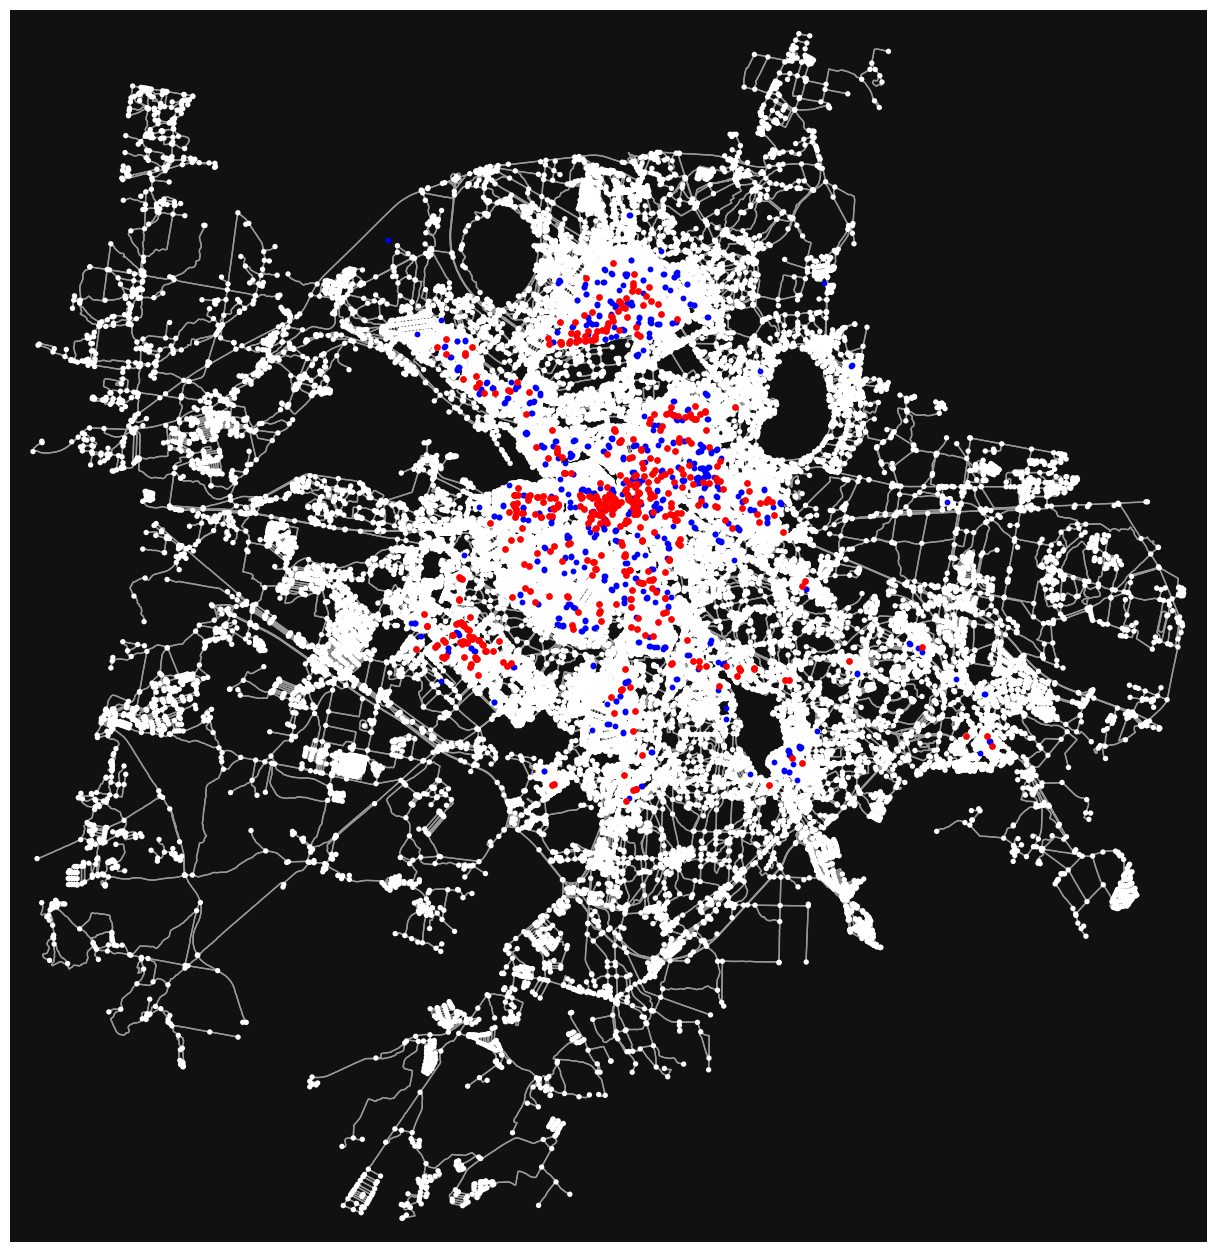

In [ ]:
fig, ax = ox.plot_graph(
                        G,
                        figsize=(16, 16),
                        show=False, close=False
                        )

ax.scatter(longitude_uch_zav, latitude_uch_zav, c='blue', s=10)#, alpha=0.3)
ax.scatter(longitude_alco, latitude_alco, c='red', s=15)#, alpha=0.3)

plt.show()

И в вышеупомянутой статье есть подсчет расстояний между точками.

In [ ]:
center_point = latitude_uch_zav.mean(), longitude_uch_zav.mean()

In [ ]:
G = ox.graph_from_point(
                        center_point,
                        dist=1000,
                        network_type='walk',
                        simplify=False
                        )

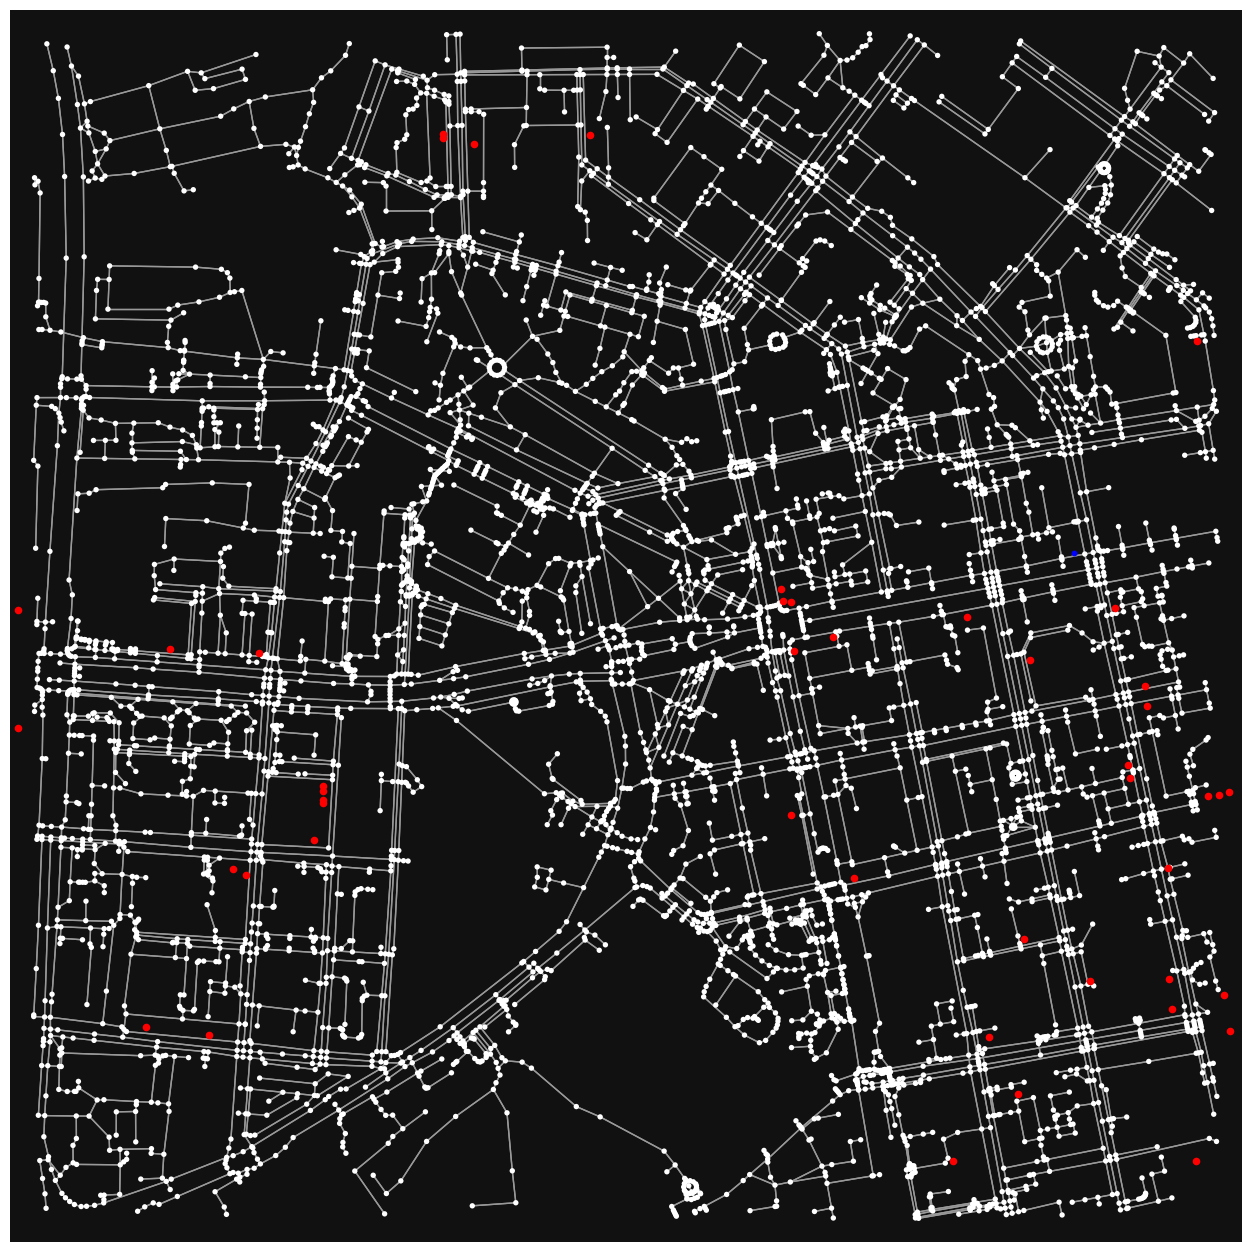

In [ ]:
fig, ax = ox.plot_graph(
                        G,
                        figsize=(16, 16),
                        show=False, close=False
                        )

longitude_school = longitude_uch_zav[2]
latitude_school = latitude_uch_zav[2]

ax.scatter(longitude_alco, latitude_alco, c='red', s=20)#, alpha=0.3)
ax.scatter(longitude_school, latitude_school, c='blue', s=10)#, alpha=0.3)

plt.show()

In [ ]:
# Найду вершины графа G, ближайшие к алко
nearest_edge_alco = ox.nearest_edges(G, longitude_alco, latitude_alco)

In [ ]:
# Найду вершины графа G, ближайшие к школе

school_point = latitude_school, longitude_school
nearest_edge_school = ox.nearest_edges(G, longitude_school, latitude_school)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nearest_edge_school

[(1367698199, 782289655, 0),
 (775458557, 4384862383, 0),
 (756099906, 9214517843, 0),
 (993583562, 1674296717, 0),
 (6711606802, 679117133, 0),
 (747722382, 5889786964, 0)]

In [ ]:
# Всего вершин

len(list(G))

5652

In [ ]:
# Нарисую один путь:

route = nx.shortest_path(G, nearest_edge_school[0][0], nearest_edge_alco[2][0])

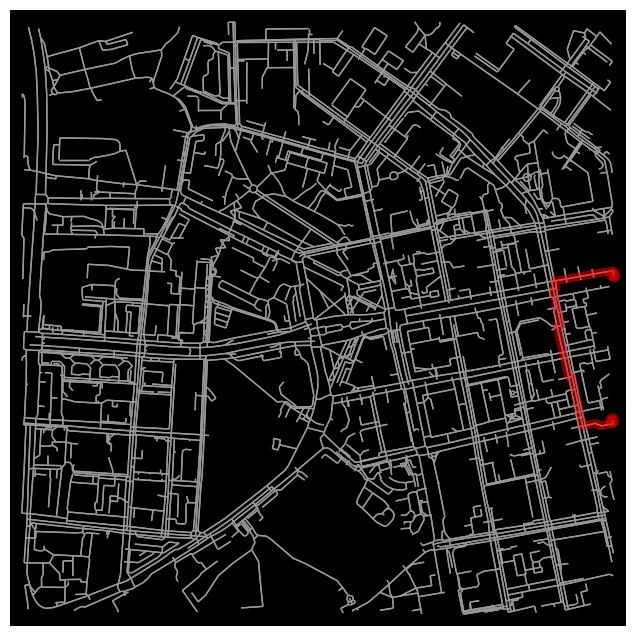

In [ ]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [ ]:
# Измеряю один путь:

G = ox.add_edge_speeds(G)

In [ ]:
route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))

<ipython-input-44-8bfa61edfd87>:1: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))


In [ ]:
print('Route  is', route_length, 'meters')

Route  is 872 meters


In [ ]:
# Теперь измеряю расстояния по всем объектам:
# Здесь надо для всех школ сделать цикл сначала и для каждой школы посчитать количество вредных точек
route_lengths = []
for i in range(len(latitude_alco)):
    route = nx.shortest_path(G, nearest_edge_school[0][0], nearest_edge_alco[i][0])
    route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
    route_lengths.append(route_length)

    print('Route  is', route_length, 'meters')

In [ ]:
schools = ox.nearest_edges(G, longitude_uch_zav, latitude_uch_zav)
schools

In [ ]:
# считаем плохие объекты для каждой школы по списку
bad_objects_near_school = []
for s in schools:
  count = 0
  for a in nearest_edge_alco:
    r = nx.shortest_path(G, s[0], a[0])  # Кратчайший путь между каждой школой и каждым плохим объектом
    r_len = int(sum(ox.utils_graph.get_route_edge_attributes(G, r, 'length')))
    if r_len < 100:
      count += 1  # +1 если путь короче 100 метров

  bad_objects_near_school.append( (s, count)  )  # Добавляем кортеж самой школы и количества плохих около нее
  if count>=0:
    print(count)



<ipython-input-68-11d40bc5358f>:7: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  r_len = int(sum(ox.utils_graph.get_route_edge_attributes(G, r, 'length')))


75
75
29
71
71
71
71
4
7
4
71
71
71
4
2
4
5
7
5
0
0
3
71
71
71
21
21
21
21
21
5
5
71
2
4
71
7
7
0
5
15
71
15
68
71
71


KeyboardInterrupt: ignored

In [ ]:
bad_objects_near_school

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[((747722382, 5889786964, 0), 75),
 ((747722382, 5889786964, 0), 75),
 ((1367698199, 782289655, 0), 29),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((674928847, 675955283, 0), 9),
 ((577536155, 9214517835, 0), 78),
 ((4370094893, 1133656800, 0), 4),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((674928847, 675955283, 0), 9),
 ((1615447134, 10581371495, 0), 2),
 ((674928847, 675955283, 0), 9),
 ((674928850, 4365482387, 0), 9),
 ((577536155, 9214517835, 0), 78),
 ((674928850, 4365482387, 0), 9),
 ((1833778142, 1833778144, 0), 0),
 ((1833778142, 1833778144, 0), 0),
 ((453228075, 453228078, 0), 3),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((415532970, 415532969, 0), 78),
 ((1931819573, 1931819565, 0), 21),
 ((1931819573, 1931819565, 0), 21),
 ((1931819573, 1931819565, 0), 21),
 ((1931819573, 1931819565, 0), 21),
